Defining an "adopted user" as a user who has logged into the product on three separate days in at least one seven­day period, identify which factors predict future user adoption.
We suggest spending 1-2 hours on this, but you're welcome to spend more or less. Please send us a brief writeup of your findings (the more concise, the better ­­ no more than one page), along with any summary tables, graphs, code, or queries that can help us understand your approach. Please note any factors you considered or investigation you did, even if they did not pan out. Feel free to identify any further research or data you think would be valuable.

In [66]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style = 'white', color_codes = True)
import numpy as np
import pandas_profiling
import eli5

In [120]:
from sklearn import preprocessing
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.cross_validation import StratifiedKFold
from sklearn.metrics import (roc_auc_score,accuracy_score, classification_report,
confusion_matrix,recall_score,precision_recall_curve,auc,roc_curve)
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.model_selection import cross_val_score

In [35]:
df_usrs = pd.read_csv('takehome_users.csv', encoding='latin-1')
df_engag = pd.read_csv('takehome_user_engagement.csv')

In [16]:
df_usrs.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [9]:
pandas_profiling.ProfileReport(df_usrs)

Number of variables,10
Number of observations,12000
Total Missing (%),7.3%
Total size in memory,937.6 KiB
Average record size in memory,80.0 B
Numeric,4
Categorical,4
Boolean,2
Date,0
Text (Unique),0
Rejected,0


In [4]:
df_engag.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [17]:
df_engag['time_stamp'] = pd.to_datetime(df_engag['time_stamp'])
df_engag['time_stamp']= df_engag['time_stamp'].dt.floor('d')
#remove duplicated days per users 
df_engag = df_engag.drop_duplicates()

In [18]:
df_engag['week'] = df_engag['time_stamp'].dt.week

In [19]:
df_2013 = df_engag [df_engag['time_stamp'].dt.year == 2013]
df_2014 = df_engag [df_engag['time_stamp'].dt.year == 2014]

In [20]:
def select(df):
  
    df_group = df.groupby(['week','user_id'])['visited'].count().reset_index(name="freq") 
    result = df_group[df_group.freq >= 3]
    
    return set(result['user_id'])

In [21]:
adopted_users_id = sorted(select(df_2013)|select(df_2014))

In [22]:
adopt_ind = np.ones(len(adopted_users_id))

In [23]:
d = {'object_id':np.array(adopted_users_id), 'adopt_ind': adopt_ind}
df_adopted = pd.DataFrame(d, columns=d.keys())

In [36]:
df = df_usrs.merge(df_adopted, how ='left')
df ['adopt_ind'].fillna(0,inplace=True)

In [93]:
df['last_session_creation_time'] =pd.to_datetime(df['last_session_creation_time'],unit='s')
df['creation_time'] = pd.to_datetime(df['creation_time'])

In [123]:
pandas_profiling.ProfileReport(df)

Number of variables,11
Number of observations,12000
Total Missing (%),6.6%
Total size in memory,1.4 MiB
Average record size in memory,123.3 B
Numeric,3
Categorical,4
Boolean,3
Date,1
Text (Unique),0
Rejected,0


/Users/zuochaozhao/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


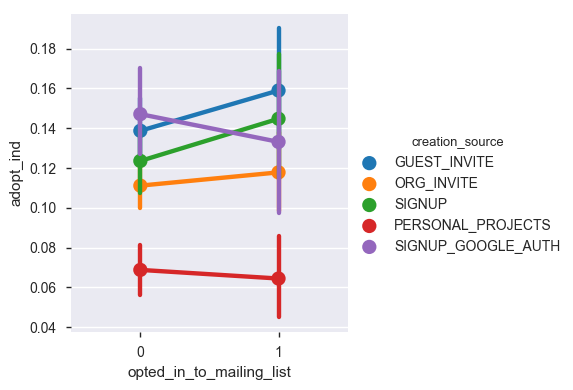

In [128]:
#pd.crosstab([data.Sex,data.Survived],data.Pclass,margins=True).style.background_gradient(cmap='summer_r')
sns.factorplot('opted_in_to_mailing_list','adopt_ind',hue='creation_source',data=df)
plt.show()

In [50]:
def count_plot(column):
    f,ax=plt.subplots(1,2,figsize=(18,8))
    df[column].value_counts().plot.bar(color=['#CD7F32','#FFDF00','#D3D3D3','#F3D3D3','#B57F12'],ax=ax[0])
    ax[0].set_title('Count of '+column)
    ax[0].set_ylabel('Count')
    sns.countplot('adopt_ind',hue=column,data=df,ax=ax[1])
    ax[1].set_title(column + ': Adopted vs Not Adopted')
    plt.show()

In [142]:
column_name = df.columns.values
column_name

array(['object_id', 'creation_time', 'name', 'email', 'creation_source',
       'last_session_creation_time', 'opted_in_to_mailing_list',
       'enabled_for_marketing_drip', 'org_id', 'invited_by_user_id',
       'adopt_ind'], dtype=object)

/Users/zuochaozhao/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


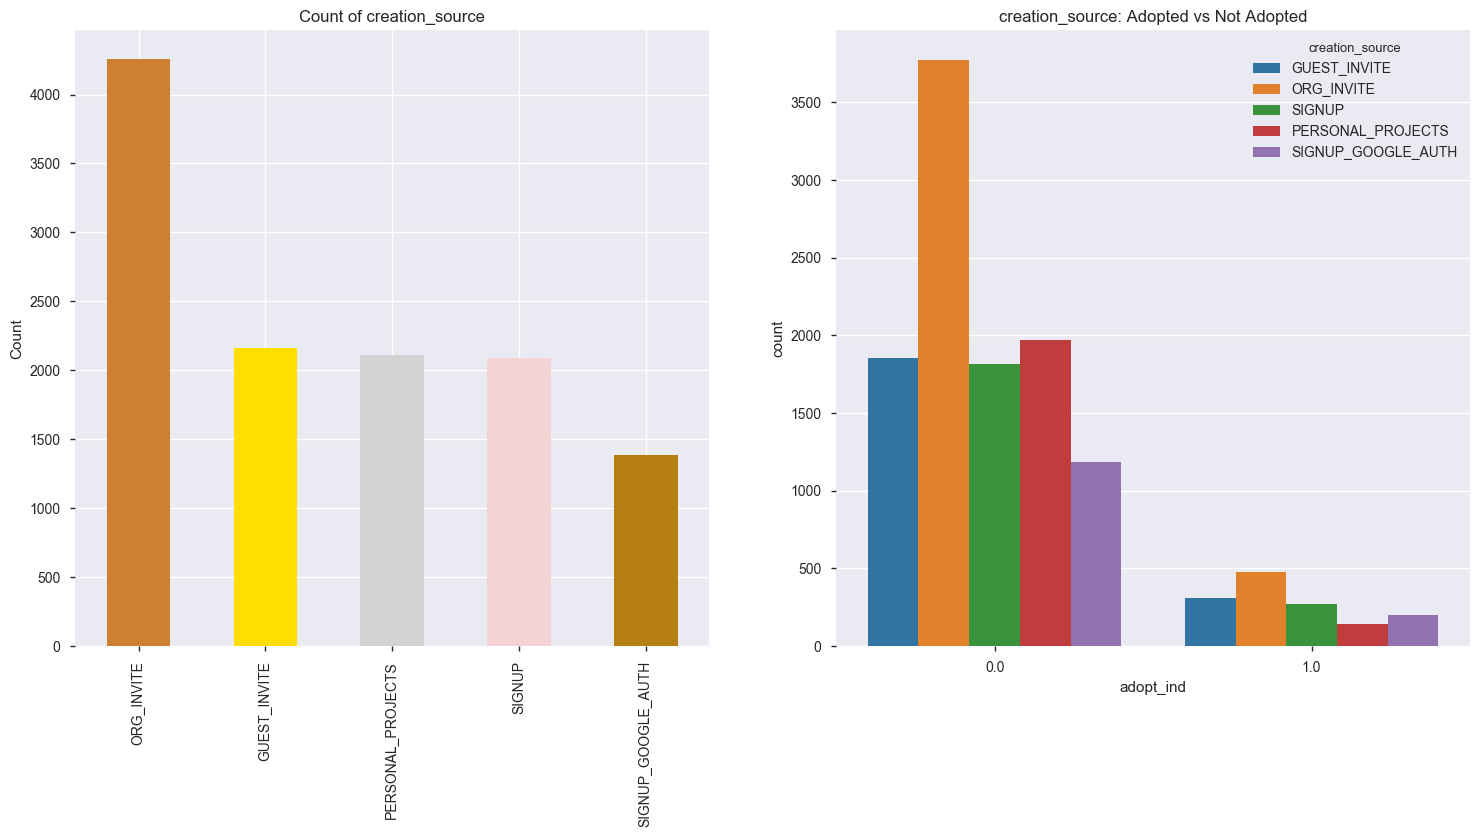

In [145]:
#creation_source
count_plot (column_name[4])

/Users/zuochaozhao/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


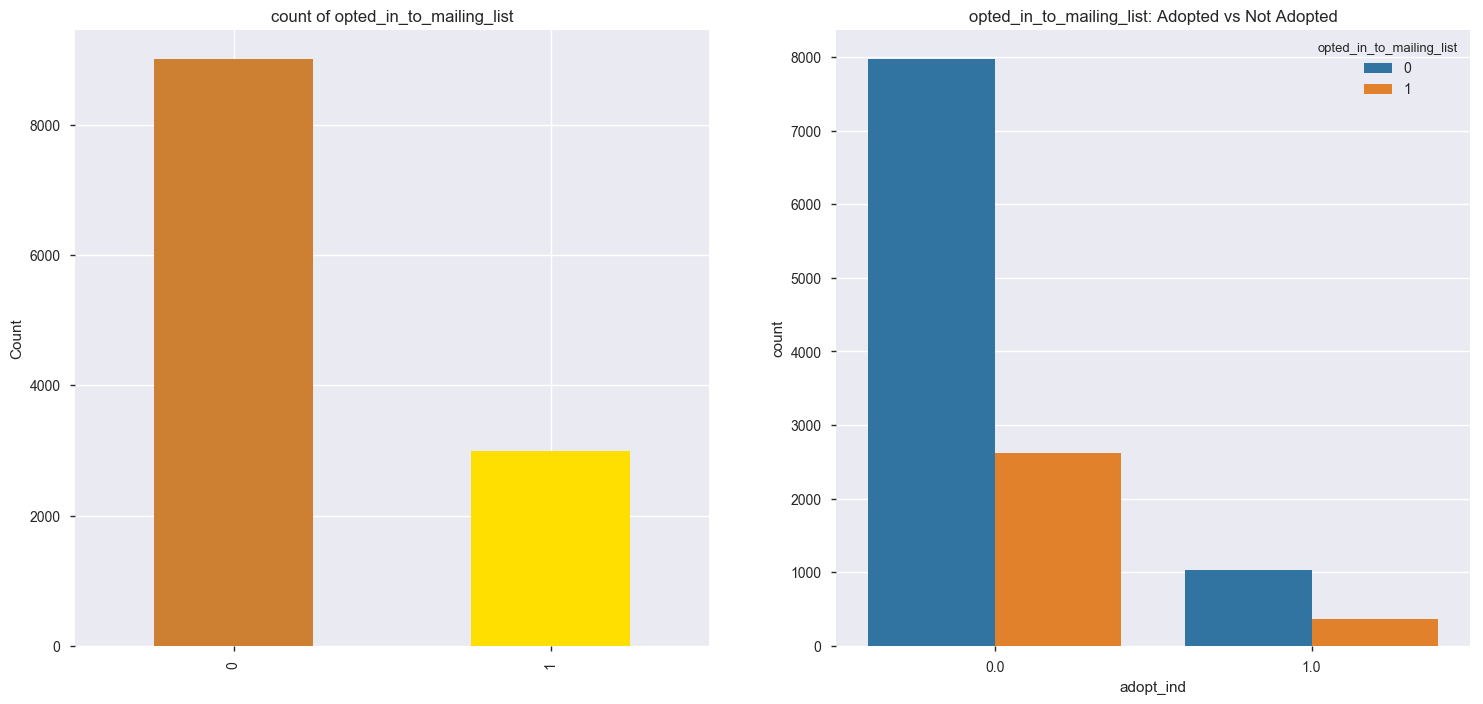

In [143]:
#opted_in_to_mailing_list
count_plot (column_name[6])

/Users/zuochaozhao/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


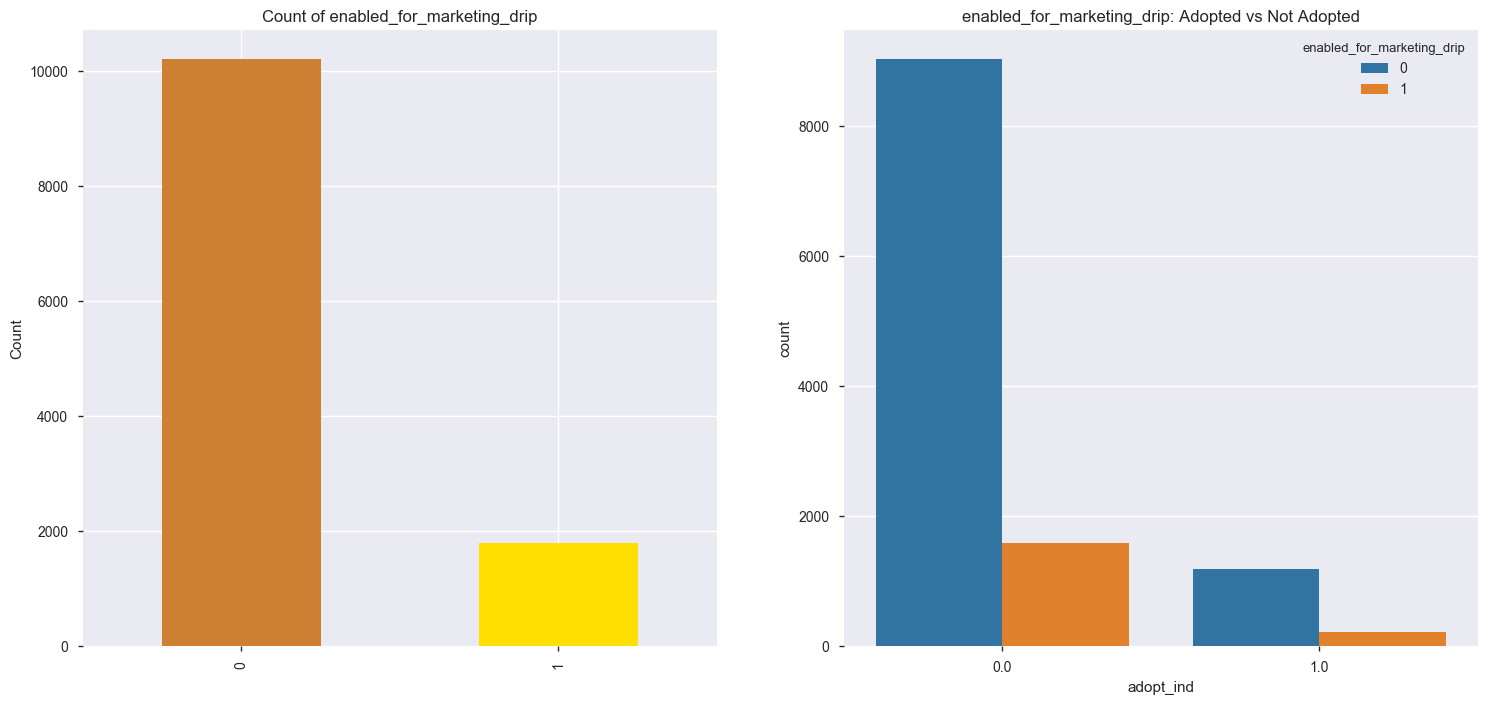

In [148]:
#enabled_for_marketing_drip
count_plot (column_name[7])

In [94]:
df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopt_ind,invited_adoption
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,0,2014-04-22 03:53:30,1,0,11,10803.0,0.0,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,1,2014-03-31 03:45:04,0,0,1,316.0,1.0,0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,1,2013-03-19 23:14:52,0,0,94,1525.0,0.0,0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,0,2013-05-22 08:09:28,0,0,1,5151.0,0.0,1
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,0,2013-01-22 10:14:20,0,0,193,5240.0,0.0,1


In [ ]:
#check id invited by user id is an adaption 

In [54]:
df['invited_adoption']= np.where(np.isin(df['invited_by_user_id'], adopted_users_id), 'yes', 'no')

/Users/zuochaozhao/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


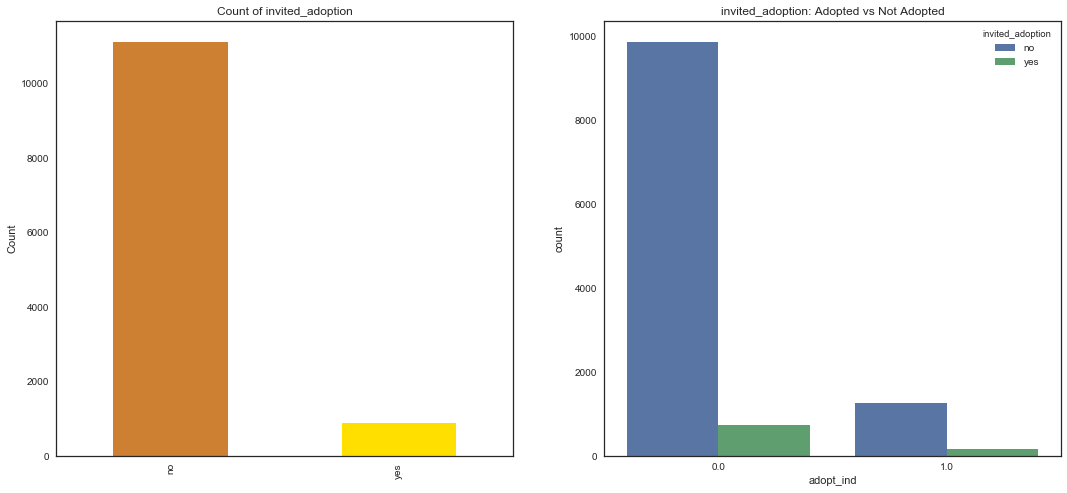

In [55]:
count_plot (column_name[-1])

In [64]:
lbl = preprocessing.LabelEncoder()
df['creation_source'] = lbl.fit_transform(df['creation_source'])
df['invited_adoption'] = lbl.fit_transform(df['invited_adoption'])

In [97]:
df.dropna(inplace = True)

In [112]:
df['active_span'] = df['last_session_creation_time']-df['creation_time']
df['active_span'] = (df['active_span']/np.timedelta64(1, 'D')).astype(int)

In [115]:
X = df.loc[:,['active_span','creation_source','org_id','opted_in_to_mailing_list','enabled_for_marketing_drip','invited_adoption']]

In [116]:
feature_names = ['active_span','creation_source','org_id','opted_in_to_mailing_list','enabled_for_marketing_drip','invited_adoption']

In [101]:
y = df.loc[:, 'adopt_ind']

In [186]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.3)
model = LogisticRegression()
X_train = np.array (X_train)
y_train = np.array (y_train).ravel()
cv_folder =4
kfolder=StratifiedKFold(y_train, n_folds= cv_folder, shuffle=True, random_state=1)
grand_auc =0.0
i = 0
for train_index, test_index in kfolder:
    X_trained, X_cv = X_train[train_index], X_train[test_index]
    y_trained, y_cv = y_train[train_index], y_train[test_index]
    model.fit(X_trained, y_trained)
    preds = model.predict_proba(X_cv)[:,1]
    auc=roc_auc_score(y_cv,preds)        
    grand_auc +=auc      
    i +=1
    
grand_auc /= cv_folder
print(grand_auc)
eli5.show_weights(model, feature_names=feature_names)

0.992093676256364


Weight?,Feature
+0.561,invited_adoption
+0.050,opted_in_to_mailing_list
+0.043,active_span
-0.001,org_id
-0.291,creation_source
-0.294,enabled_for_marketing_drip
-4.282,<BIAS>


In [192]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.3)
model = LogisticRegression(penalty ='l1', C=0.5, random_state =1)
X_train = np.array (X_train)
y_train = np.array (y_train).ravel()
cv_folder =4
kfolder=StratifiedKFold(y_train, n_folds= cv_folder, shuffle=True, random_state=1)
grand_auc =0.0
i = 0
for train_index, test_index in kfolder:
    X_trained, X_cv = X_train[train_index], X_train[test_index]
    y_trained, y_cv = y_train[train_index], y_train[test_index]
    model.fit(X_trained, y_trained)
    preds = model.predict_proba(X_cv)[:,1]
    auc=roc_auc_score(y_cv,preds)        
    grand_auc +=auc      
    i +=1
    
grand_auc /= cv_folder
print(grand_auc)
eli5.show_weights(model, feature_names=feature_names)

0.9924124008297248


Weight?,Feature
+0.460,invited_adoption
+0.044,active_span
-0.000,org_id
-0.015,enabled_for_marketing_drip
-0.081,creation_source
-4.605,<BIAS>


In [190]:
preds=model.predict_proba(X_test)[:,1]
auc=roc_auc_score(y_test,preds)      
auc

0.9924597036795832

In [172]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.3)
model = RandomForestClassifier()
X_train = np.array (X_train)
y_train = np.array (y_train).ravel()
cv_folder =4
kfolder=StratifiedKFold(y_train, n_folds= cv_folder, shuffle=True, random_state=1)
grand_auc =0.0
i = 0
for train_index, test_index in kfolder:
    X_trained, X_cv = X_train[train_index], X_train[test_index]
    y_trained, y_cv = y_train[train_index], y_train[test_index]
    model.fit(X_trained, y_trained)
    preds = model.predict_proba(X_cv)[:,1]
    auc=roc_auc_score(y_cv,preds)        
    grand_auc +=auc      
    i +=1
    
grand_auc /= cv_folder
print(grand_auc)
eli5.show_weights(model, feature_names=feature_names)

0.974070429667746


Weight,Feature
0.8895 ± 0.0275,active_span
0.0841 ± 0.0218,org_id
0.0109 ± 0.0122,creation_source
0.0077 ± 0.0102,invited_adoption
0.0040 ± 0.0070,enabled_for_marketing_drip
0.0038 ± 0.0038,opted_in_to_mailing_list


In [173]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.3)
model = RandomForestClassifier(max_depth = 5, random_state =1)
X_train = np.array (X_train)
y_train = np.array (y_train).ravel()
cv_folder =4
kfolder=StratifiedKFold(y_train, n_folds= cv_folder, shuffle=True, random_state=1)
grand_auc =0.0
i = 0
for train_index, test_index in kfolder:
    X_trained, X_cv = X_train[train_index], X_train[test_index]
    y_trained, y_cv = y_train[train_index], y_train[test_index]
    model.fit(X_trained, y_trained)
    preds = model.predict_proba(X_cv)[:,1]
    auc=roc_auc_score(y_cv,preds)        
    grand_auc +=auc      
    i +=1
    
grand_auc /= cv_folder
print(grand_auc)
eli5.show_weights(model, feature_names=feature_names)

0.9866597711857765


Weight,Feature
0.9625 ± 0.0326,active_span
0.0232 ± 0.0181,org_id
0.0056 ± 0.0105,creation_source
0.0044 ± 0.0063,invited_adoption
0.0027 ± 0.0058,opted_in_to_mailing_list
0.0017 ± 0.0032,enabled_for_marketing_drip


In [177]:
preds=model.predict_proba(X_test)[:,1]
auc=roc_auc_score(y_test,preds)      
auc

0.9859692146966242